## Part 6 - Linear Regression of Vegetation Composition against Climate Variables
#### Notebook outline:

This notebook outlines calculates the fractional cover of vegetation from one class to another and the performs a linear regression based on different variables.

This function requires the following libraries:

In [58]:
import rasterio
import xarray as xr

import rioxarray as rio
from rasterio.plot import show
from rasterio.windows import from_bounds

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from  matplotlib.cm import ScalarMappable
from  matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FormatStrFormatter


import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline

import seaborn as sns

import scipy as sp
from scipy import stats

##### Function:
This function plots the linear regression for all climate variables against the specified vegetation class for a specified sample site.

In [1]:
def linear_regression(sample_site,veg_variable='Forest'):
    
    """
    This function plots a series of linear regressions for each cliamte variable against the percentage composition of the defined vegetation class.
    
    Variables:
    sample_site = site name for title label and file name (Follow convention 'Control Site' or 'Sample Site #')
    veg_variable = Vegetation class to plot against - default is 'Forest'. 'Pasture' and 'Floodable Forest' are the other two options. 
        Please note the 'Floodable Forest is only found in the Control Site' and 'Pasture' is only found in the sample sites.
    
    """
    
    
    
    # read input csv file
    vegdf = pd.read_csv('vegetation_analysis_sample_site_perc_'+str(sample_site)+'_1985-2022.csv', index_col ="Classes")

    # drop columns from before 2000
    vegdf = vegdf.drop(columns=['perc1985', 'perc1986',
                              'perc1987', 'perc1988', 
                              'perc1989', 'perc1990', 
                              'perc1991', 'perc1992',
                              'perc1993', 'perc1994',
                              'perc1995', 'perc1996', 
                              'perc1997', 'perc1998', 'perc1999'])

    # drop rows with no values
    vegdf = vegdf[(vegdf != 0).all(1)]

    # extract relevant rows

    if sample_site == 'Sample Site 1':
        row_number_first = 0
        row_number_second = 5
        row_name_first = 'Forest'
        row_name_second = 'Pasture'
    elif  sample_site == 'Sample Site 2':
        row_number_first = 0
        row_number_second = 5
        row_name_first = 'Forest'
        row_name_second = 'Pasture'
    elif sample_site == 'Sample Site 3':
        row_number_first = 0
        row_number_second = 6
        row_name_first = 'Forest'
        row_name_second = 'Pasture'
    elif sample_site == 'Sample Site 4':
        row_number_first = 0
        row_number_second = 6
        row_name_first = 'Forest'
        row_name_second = 'Pasture'
    else:
        row_number_first = 0
        row_number_second = 1
        row_name_first = 'Forest'
        row_name_second = 'Floodable Forest'

    first = vegdf.iloc[row_number_first:(row_number_first+1)] 
    second = vegdf.iloc[row_number_second:(row_number_second+1)]

    # append relevant rows
    first = first.reset_index()
    first.rename(index={0: row_name_first}, inplace=True)
    first = first.iloc[: , 1:]

    second = second.reset_index()
    second.rename(index={0: row_name_second}, inplace=True)
    second = second.iloc[: , 1:]

    frames = [first,second]

    result = pd.concat(frames)

    # rename rows and columns
    result = result.rename(columns={'perc2000' :'2000',
                              'perc2001' :'2001',
                              'perc2002' :'2002', 
                              'perc2003' :'2003', 
                              'perc2004' :'2004', 
                              'perc2005' :'2005', 
                              'perc2006' :'2006', 
                              'perc2007' :'2007',
                              'perc2008' :'2008', 
                              'perc2009' :'2009',
                              'perc2010' :'2010', 
                              'perc2011' :'2011', 
                              'perc2012' :'2012', 
                              'perc2013' :'2013', 
                              'perc2014' :'2014', 
                              'perc2015' :'2015',
                              'perc2016' :'2016', 
                              'perc2017' :'2017',
                              'perc2018' :'2018', 
                              'perc2019' :'2019', 
                              'perc2020' :'2020', 
                              'perc2021' :'2021', 
                              'perc2022' :'2022'})
    result = result.transpose()

    # read input climate csv file

    if sample_site == 'Sample Site 1':
        climate_sample_site = 'Site_1'
    elif  sample_site == 'Sample Site 2':
        climate_sample_site = 'Site_2'
    elif sample_site == 'Sample Site 3':
        climate_sample_site = 'Site_3'
    elif sample_site == 'Sample Site 4':
        climate_sample_site = 'Site_4'
    else:
        climate_sample_site = 'Control_site'

    tempdf = pd.read_csv(''+str(climate_sample_site)+'_climate_ds.csv', index_col = 'time')

    # rename dates to match
    tempdf = tempdf.transpose()
    tempdf = tempdf.rename(columns={'2000-12-31' :'2000',
                              '2001-12-31' :'2001',
                              '2002-12-31' :'2002', 
                              '2003-12-31' :'2003', 
                              '2004-12-31' :'2004', 
                              '2005-12-31' :'2005', 
                              '2006-12-31' :'2006', 
                              '2007-12-31' :'2007',
                              '2008-12-31' :'2008', 
                              '2009-12-31' :'2009',
                              '2010-12-31' :'2010', 
                              '2011-12-31' :'2011', 
                              '2012-12-31' :'2012', 
                              '2013-12-31' :'2013', 
                              '2014-12-31' :'2014', 
                              '2015-12-31' :'2015',
                              '2016-12-31' :'2016', 
                              '2017-12-31' :'2017',
                              '2018-12-31' :'2018', 
                              '2019-12-31' :'2019', 
                              '2020-12-31' :'2020', 
                              '2021-12-31' :'2021', 
                              '2022-12-31' :'2022'})

    tempdf = tempdf.transpose()

    #join veg and climate data
    resultgraph = pd.concat([result, tempdf], axis=1, join="inner")

    #drop 2000 and 2001 from combined dataset to match albedo set

    resultgraph = resultgraph.transpose()
    resultgraph = resultgraph.drop(columns={'2000','2001'})
    resultgraph = resultgraph.transpose()

    # read input albedo csv file

    if sample_site == 'Sample Site 1':
        climate_sample_site = 'Site_1'
    elif  sample_site == 'Sample Site 2':
        climate_sample_site = 'Site_2'
    elif sample_site == 'Sample Site 3':
        climate_sample_site = 'Site_3'
    elif sample_site == 'Sample Site 4':
        climate_sample_site = 'Site_4'
    else:
        climate_sample_site = 'Control_site'

    albedodf = pd.read_csv(''+str(climate_sample_site)+'_albedo_yr.csv',index_col=0)

    #join albedo data to veg and other climate data
    resultgraph = resultgraph.reset_index()
    albedodf = albedodf.reset_index()
    albedodf = albedodf.drop(columns={'index'})
    resultgraph = pd.concat([resultgraph, albedodf], axis=1, join="inner")
    resultgraph = resultgraph.rename(columns={'index' :'Year'})

    resultgraph.to_csv('vegetation_climate_data_'+str(sample_site)+'.csv',index=False)

    #define plotting region (2 rows, 3 columns)
    fig, axes = plt.subplots(2, 3,figsize=(20, 12))

    #create scatter plot for each variable
    fig.suptitle(sample_site, fontsize=18)    
    fig.subplots_adjust(top = 0.92)

    r1, p1 = sp.stats.pearsonr(x=resultgraph[veg_variable], y=resultgraph['tmin'])
    r1value = str('r2={:.2f}'.format(r1))
    ax1 = sns.scatterplot(x = veg_variable, y = 'tmin', data=resultgraph, hue='Year',ax=axes[0,0],legend=False)
    ax1 = sns.regplot(x = veg_variable, y = 'tmin', data=resultgraph, fit_reg=True,scatter=False,ax=axes[0,0]
                     ).set(title='Min Temperature')
    y1min, y1max = axes[0,0].get_ylim()
    label1y = y1max-((y1max-y1min)/8)
    x1min, x1max = axes[0,0].get_xlim()
    label1x = x1max-((x1max-x1min)/6)
    axes[0,0].text(label1x, label1y,r1value, fontsize=9)
    axes[0,0].set_xlabel(str(veg_variable)+' % Composition')
    axes[0,0].set_ylabel('Min Temp (°C)')

    r2, p2 = sp.stats.pearsonr(x=resultgraph[veg_variable], y=resultgraph['tmax'])
    r2value = str('r2={:.2f}'.format(r2))
    ax2 = sns.scatterplot(x = veg_variable, y = 'tmax', data=resultgraph, hue='Year',ax=axes[0,1],legend=False)
    ax2 = sns.regplot(x = veg_variable, y = 'tmax', data=resultgraph, fit_reg=True,scatter=False,ax=axes[0,1],
                      ).set(title='Max Temperature')
    y2min, y2max = axes[0,1].get_ylim()
    label2y = y2max-((y2max-y2min)/8)
    x2min, x2max = axes[0,1].get_xlim()
    label2x = x2max-((x2max-x2min)/6)
    axes[0,1].text(label2x, label2y,r2value, fontsize=9)
    axes[0,1].set_xlabel(str(veg_variable)+' % Composition')
    axes[0,1].set_ylabel('Max Temp (°C)')

    r3, p3 = sp.stats.pearsonr(x=resultgraph[veg_variable], y=resultgraph['mean temp'])
    r3value = str('r2={:.2f}'.format(r3))
    ax3 = sns.scatterplot(x = veg_variable, y = 'mean temp', data=resultgraph, hue='Year',ax=axes[0,2],legend=True)
    sns.move_legend(ax3, "upper left", bbox_to_anchor=(1, 1))
    ax3 = sns.regplot(x = veg_variable, y = 'mean temp', data=resultgraph, fit_reg=True,scatter=False,ax=axes[0,2],
                     ).set(title='Min Temperature')
    y3min, y3max = axes[0,2].get_ylim()
    label3y = y3max-((y3max-y3min)/8)
    x3min, x3max = axes[0,2].get_xlim()
    label3x = x3max-((x3max-x3min)/6)
    axes[0,2].text(label3x, label3y,r3value, fontsize=9)
    axes[0,2].set_xlabel(str(veg_variable)+' % Composition')
    axes[0,2].set_ylabel('Mean Temp (°C)')

    r4, p4 = sp.stats.pearsonr(x=resultgraph[veg_variable], y=resultgraph['aet'])
    r4value = str('r2={:.2f}'.format(r4))
    ax4 = sns.scatterplot(x = veg_variable, y = 'aet', data=resultgraph, hue='Year',ax=axes[1,0],legend=False)
    ax4 = sns.regplot(x = veg_variable, y = 'aet', data=resultgraph, fit_reg=True,scatter=False,ax=axes[1,0],
                      ).set(title='Evapotranspiration')
    y4min, y4max = axes[1,0].get_ylim()
    label4y = y4max-((y4max-y4min)/8)
    x4min, x4max = axes[1,0].get_xlim()
    label4x = x4max-((x4max-x4min)/6)
    axes[1,0].text(label4x, label4y,r4value, fontsize=9)
    axes[1,0].set_xlabel(str(veg_variable)+' % Composition')
    axes[1,0].set_ylabel('Actual Evapotranspiration (mm)')

    r5, p5 = sp.stats.pearsonr(x=resultgraph[veg_variable], y=resultgraph['ppt'])
    r5value = str('r2={:.2f}'.format(r5))
    ax5 = sns.scatterplot(x = veg_variable, y = 'ppt', data=resultgraph, hue='Year',ax=axes[1,1],legend=False)
    ax5 = sns.regplot(x = veg_variable, y = 'ppt', data=resultgraph, fit_reg=True,scatter=False,ax=axes[1,1],
                      ).set(title='Precipitation')
    y5min, y5max = axes[1,1].get_ylim()
    label5y = y5max-((y5max-y5min)/8)
    x5min, x5max = axes[1,1].get_xlim()
    label5x = x5max-((x5max-x5min)/6)
    axes[1,1].text(label5x, label5y,r5value, fontsize=9)
    axes[1,1].set_xlabel(str(veg_variable)+' % Composition')
    axes[1,1].set_ylabel('Precipitation (mm)')

    r6, p6 = sp.stats.pearsonr(x=resultgraph[veg_variable], y=resultgraph['albedo'])
    r6value = str('r2={:.2f}'.format(r6))
    ax6 = sns.scatterplot(x = veg_variable, y = 'albedo', data=resultgraph, hue='Year',ax=axes[1,2],legend=False)
    ax6 = sns.regplot(x = veg_variable, y = 'albedo', data=resultgraph, fit_reg=True,scatter=False,ax=axes[1,2],
                      ).set(title='Albedo')
    y6min, y6max = axes[1,2].get_ylim()
    label6y = y6max-((y6max-y6min)/8)
    x6min, x6max = axes[1,2].get_xlim()
    label6x = x6max-((x6max-x6min)/6)
    axes[1,2].text(label6x, label6y,r6value, fontsize=9)
    axes[1,2].set_xlabel(str(veg_variable)+' % Composition')
    axes[1,2].set_ylabel('Albedo')
    
    plt.savefig('linear_regression_'+str(sample_site)+'_'+str(veg_variable)+'.png', bbox_inches='tight', dpi=100)
   
    return

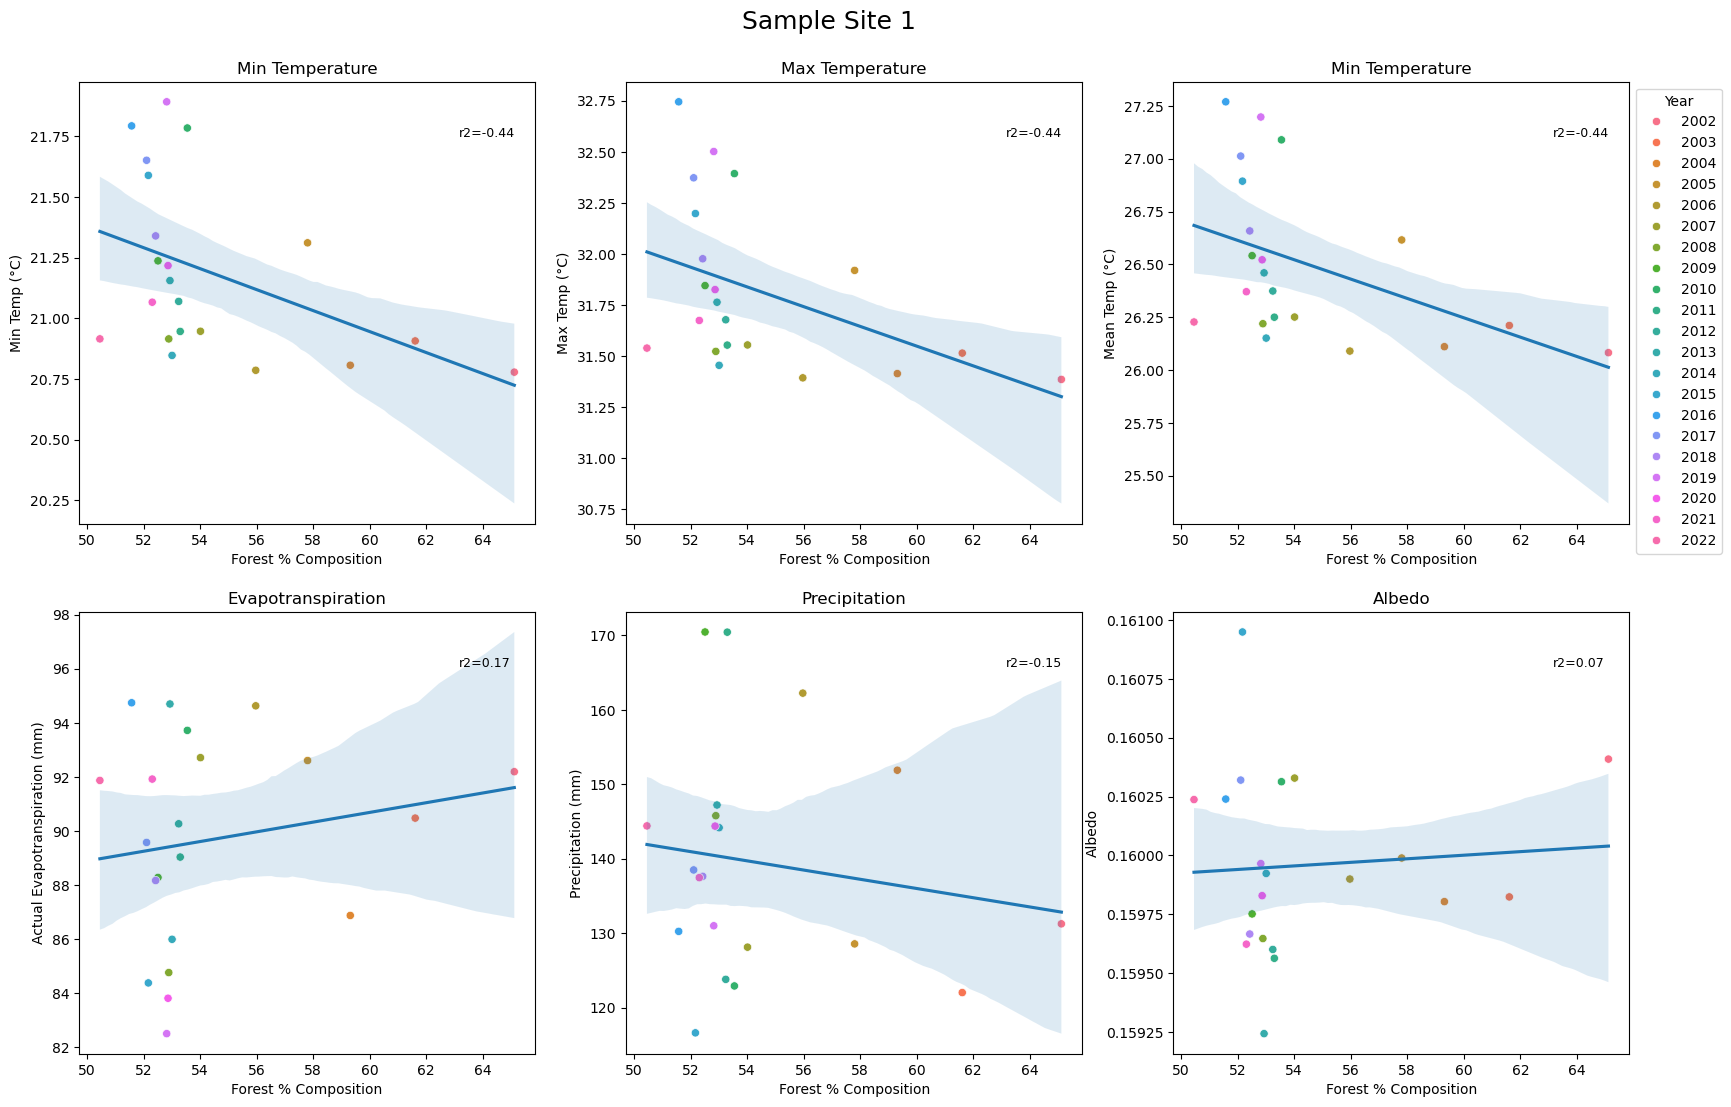

In [802]:
linear_regression('Sample Site 1','Forest')

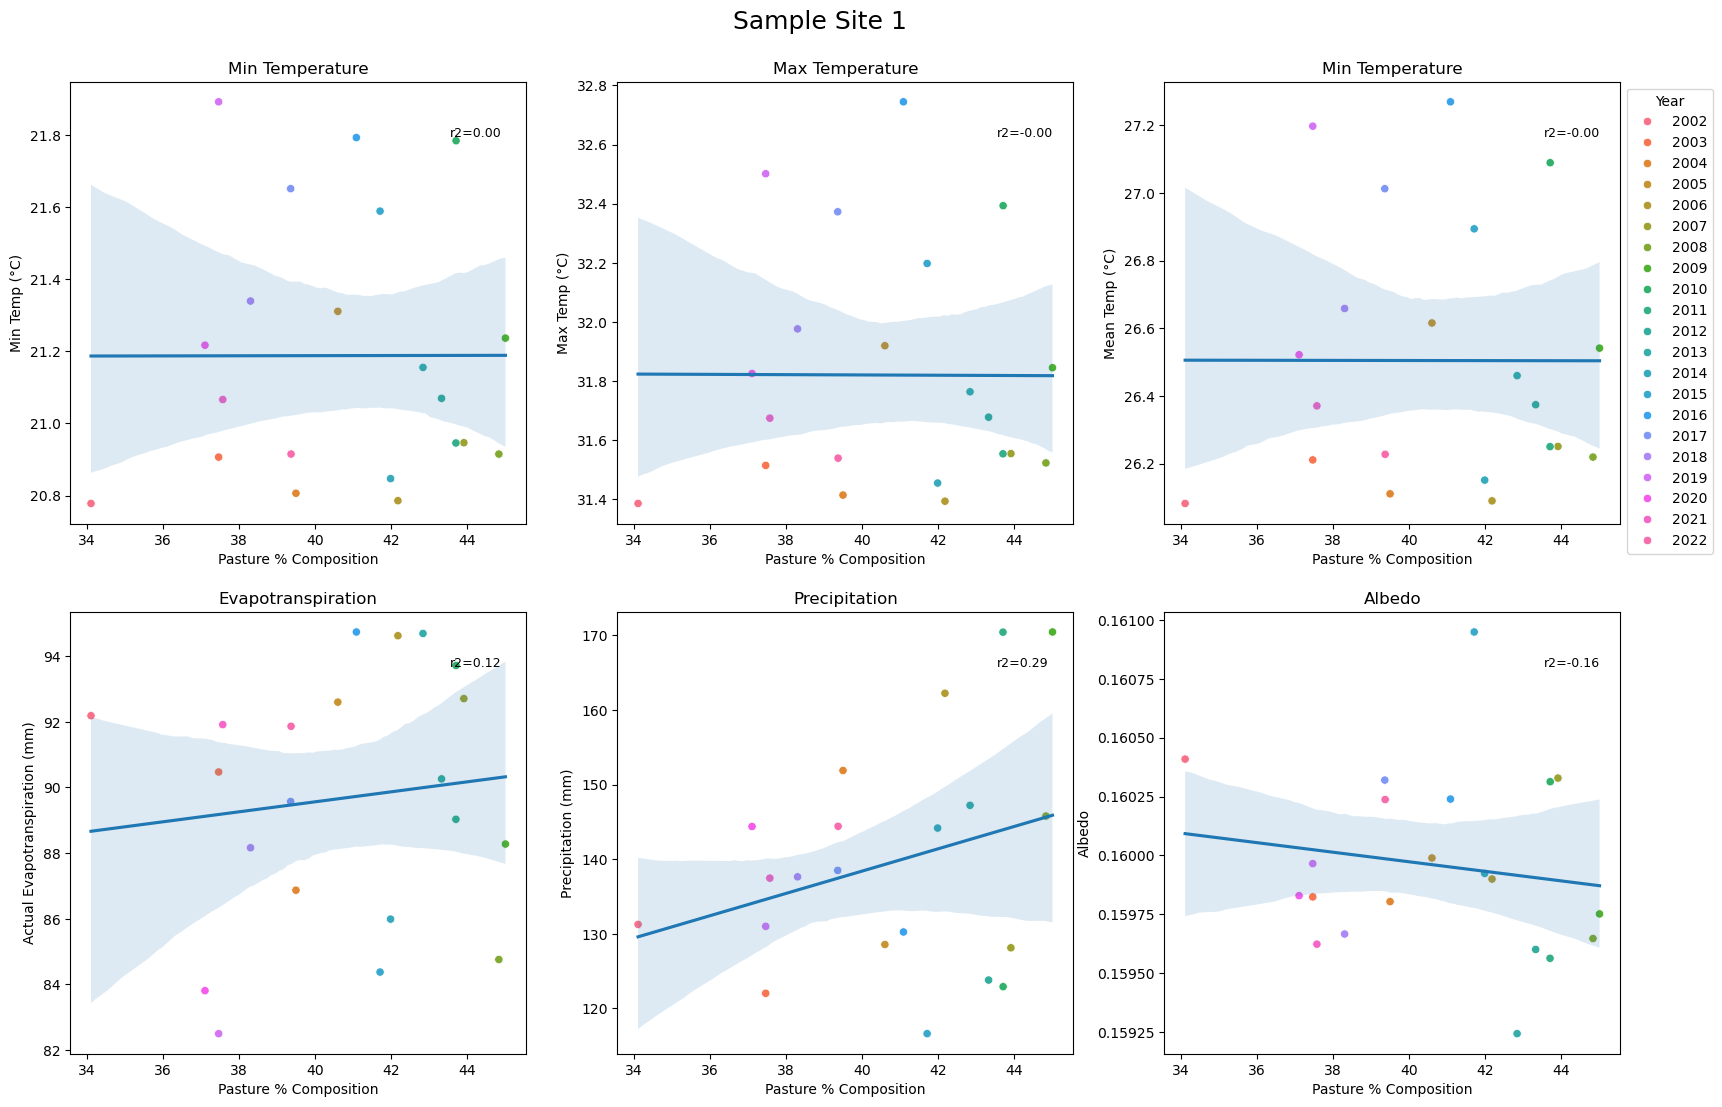

In [803]:
linear_regression('Sample Site 1','Pasture')

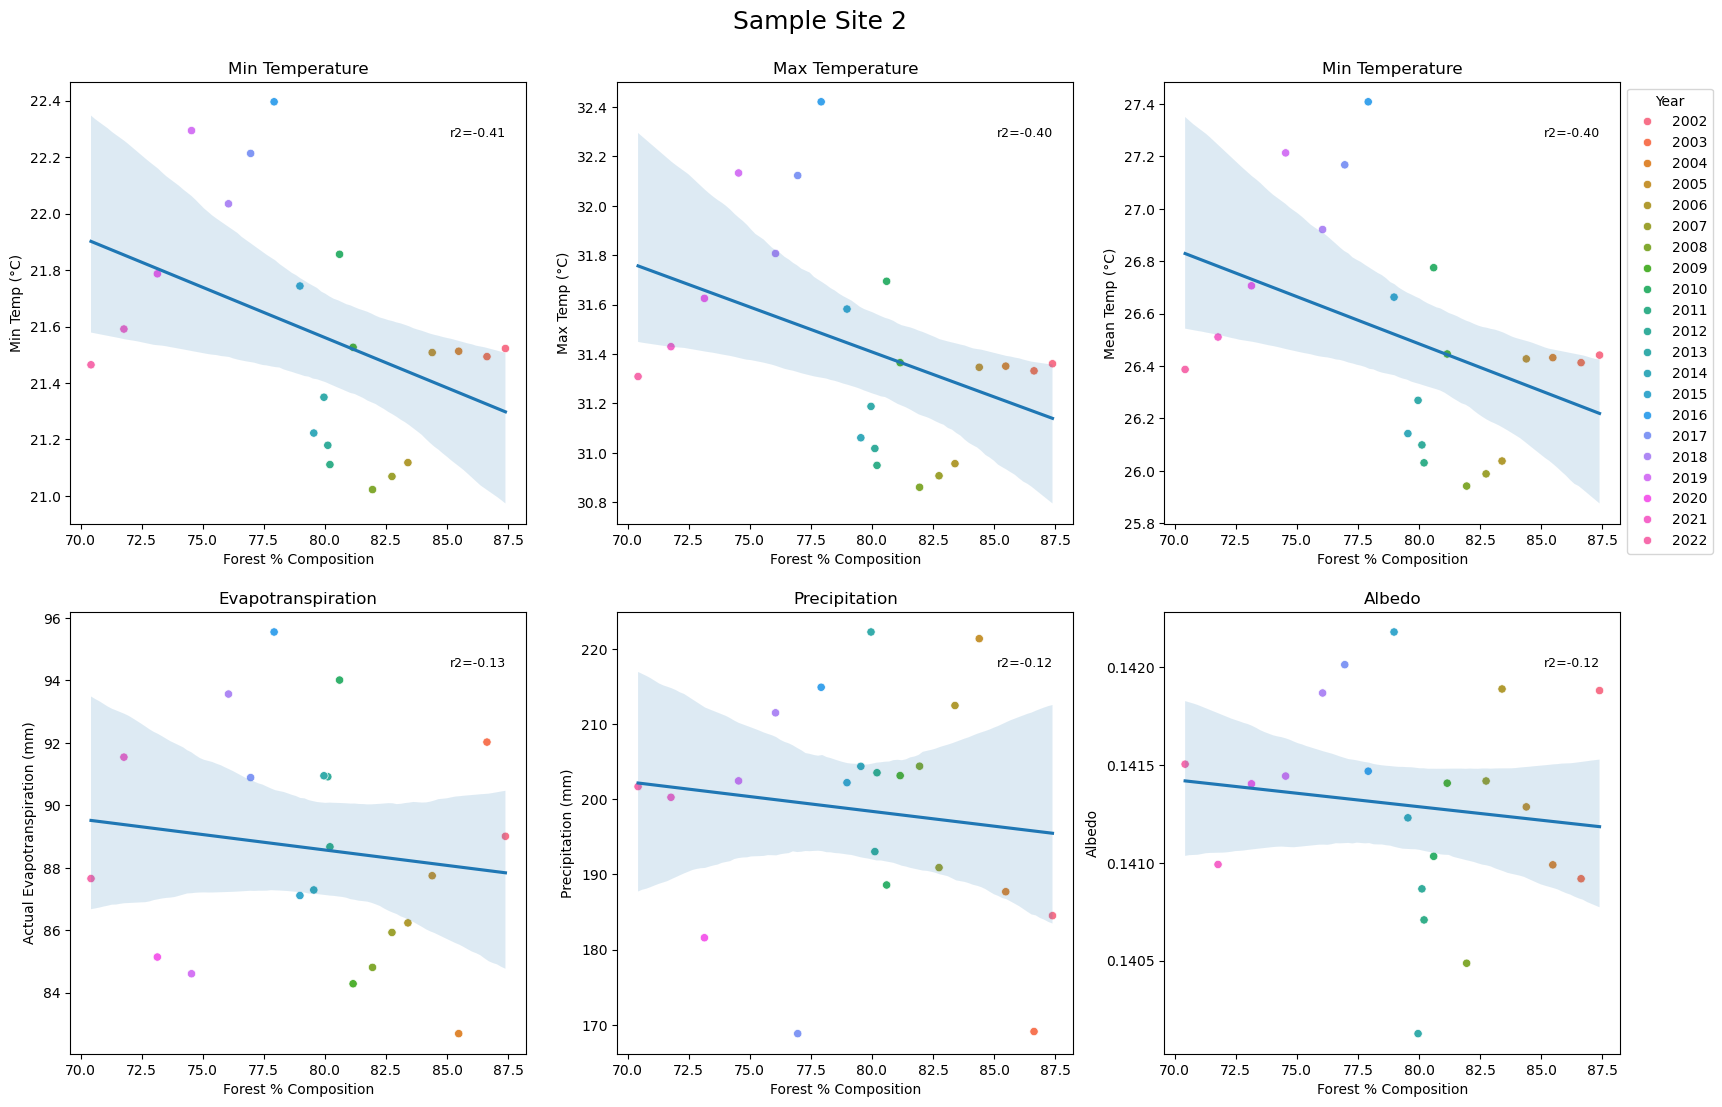

In [804]:
linear_regression('Sample Site 2','Forest')

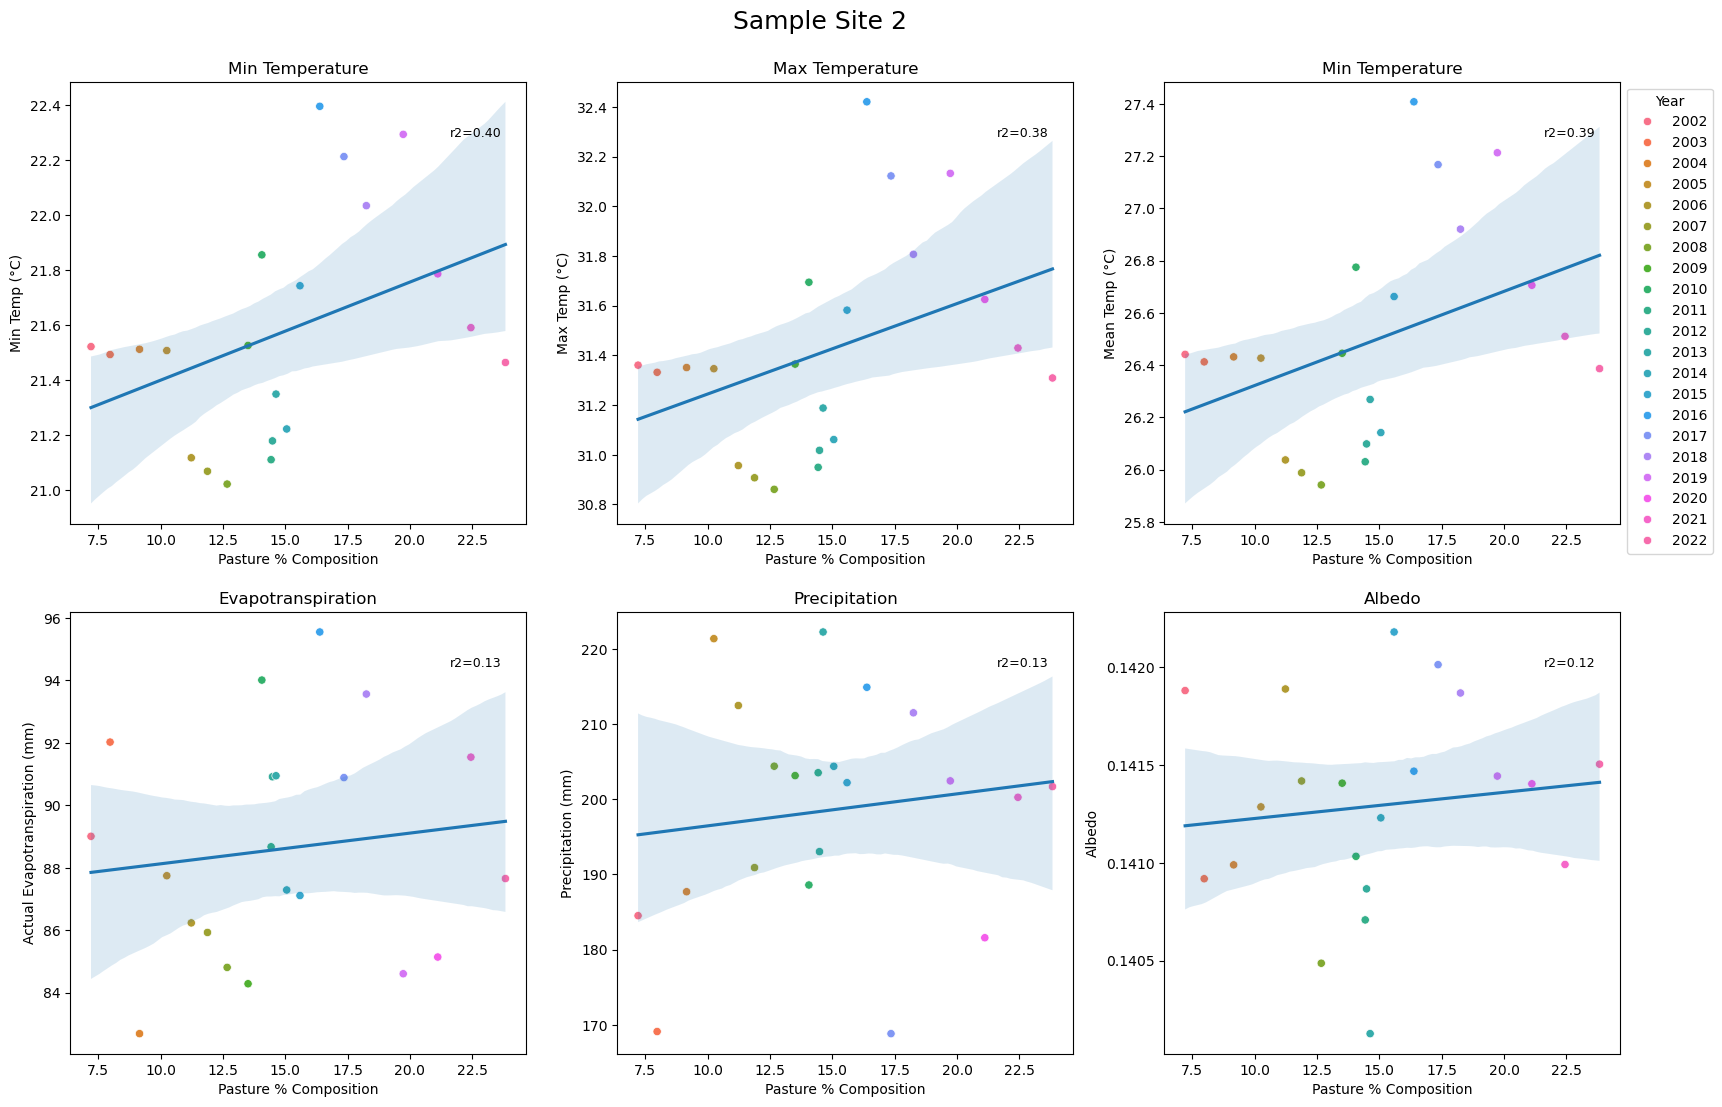

In [805]:
linear_regression('Sample Site 2','Pasture')

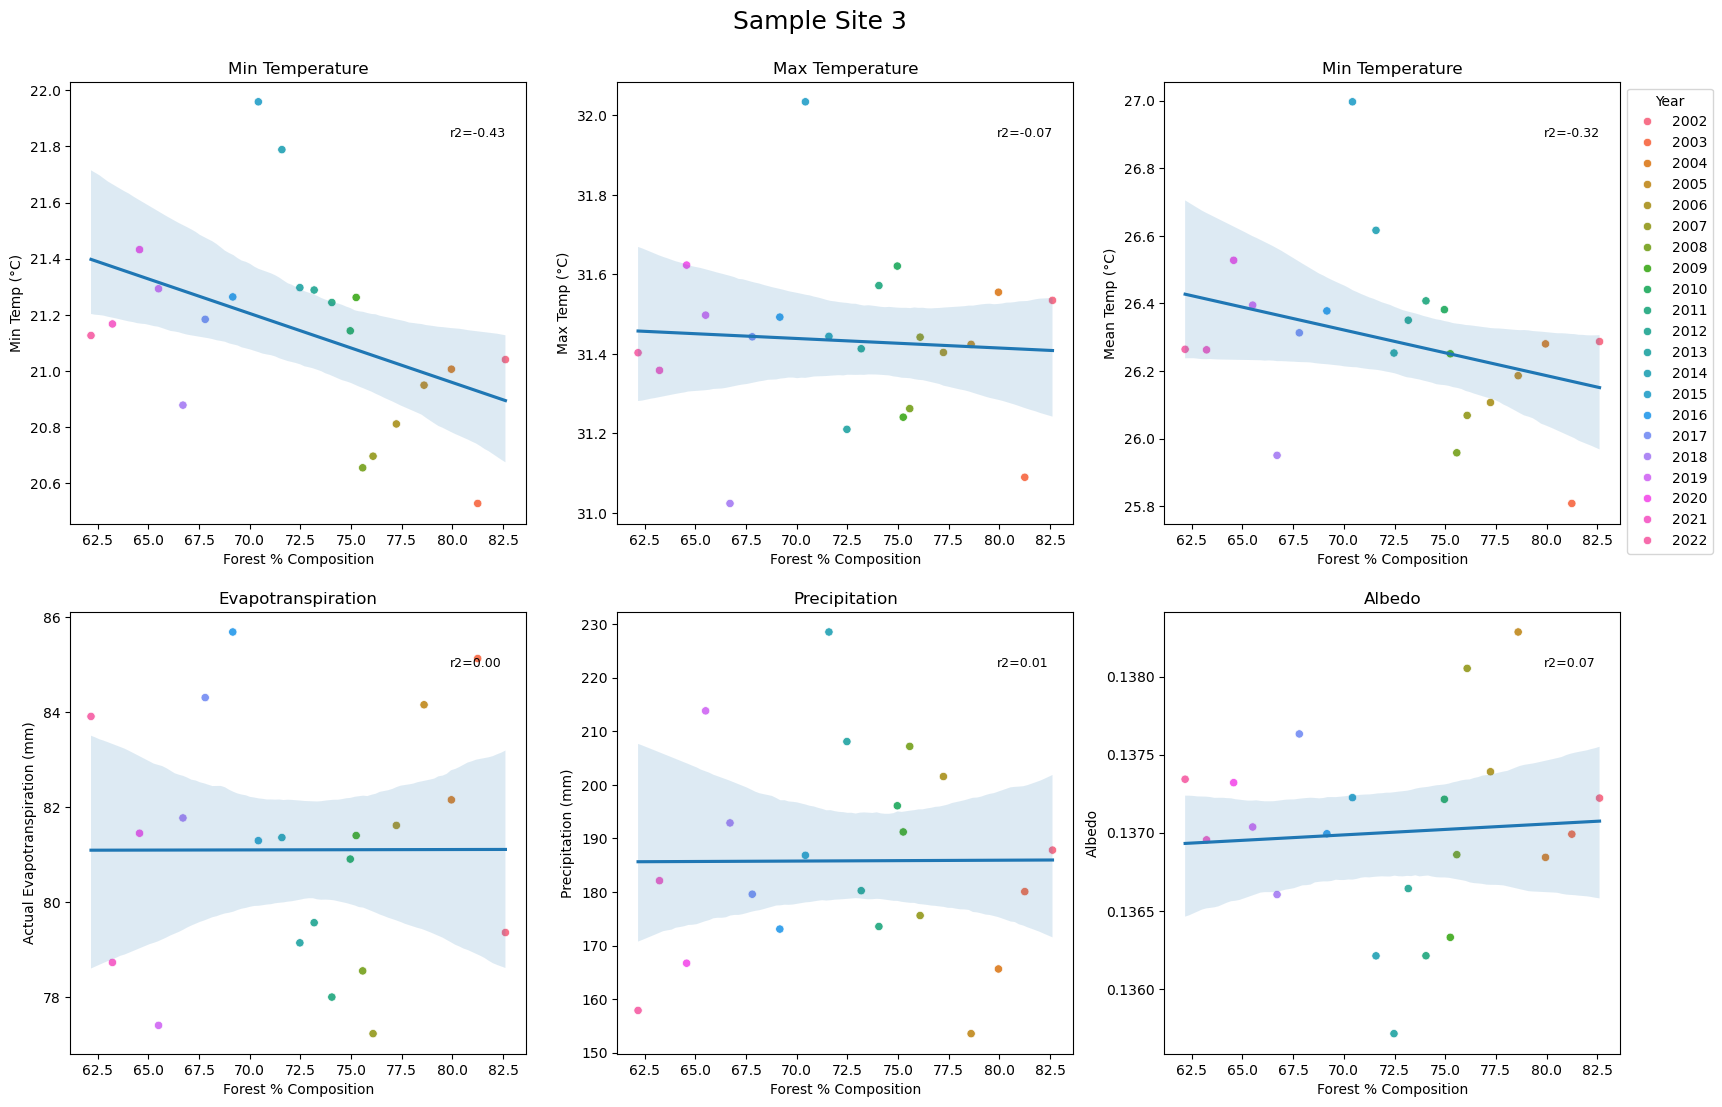

In [807]:
linear_regression('Sample Site 3','Forest')

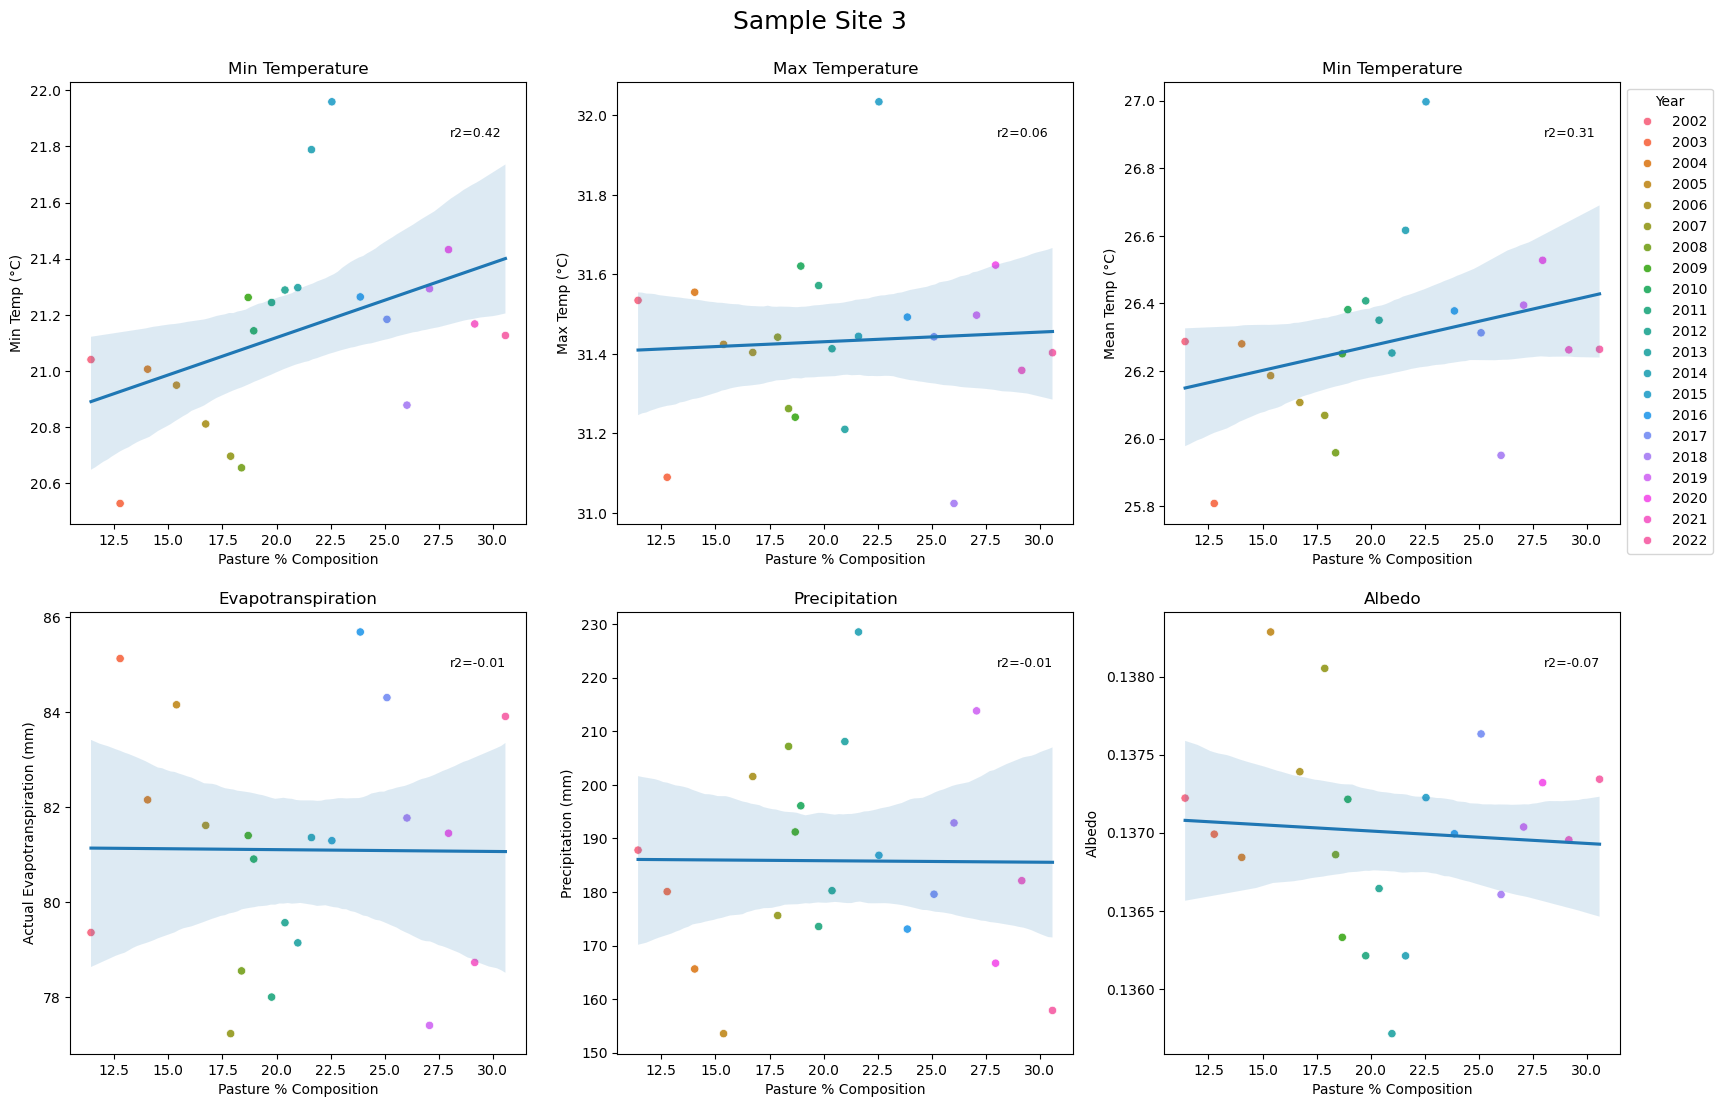

In [808]:
linear_regression('Sample Site 3','Pasture')

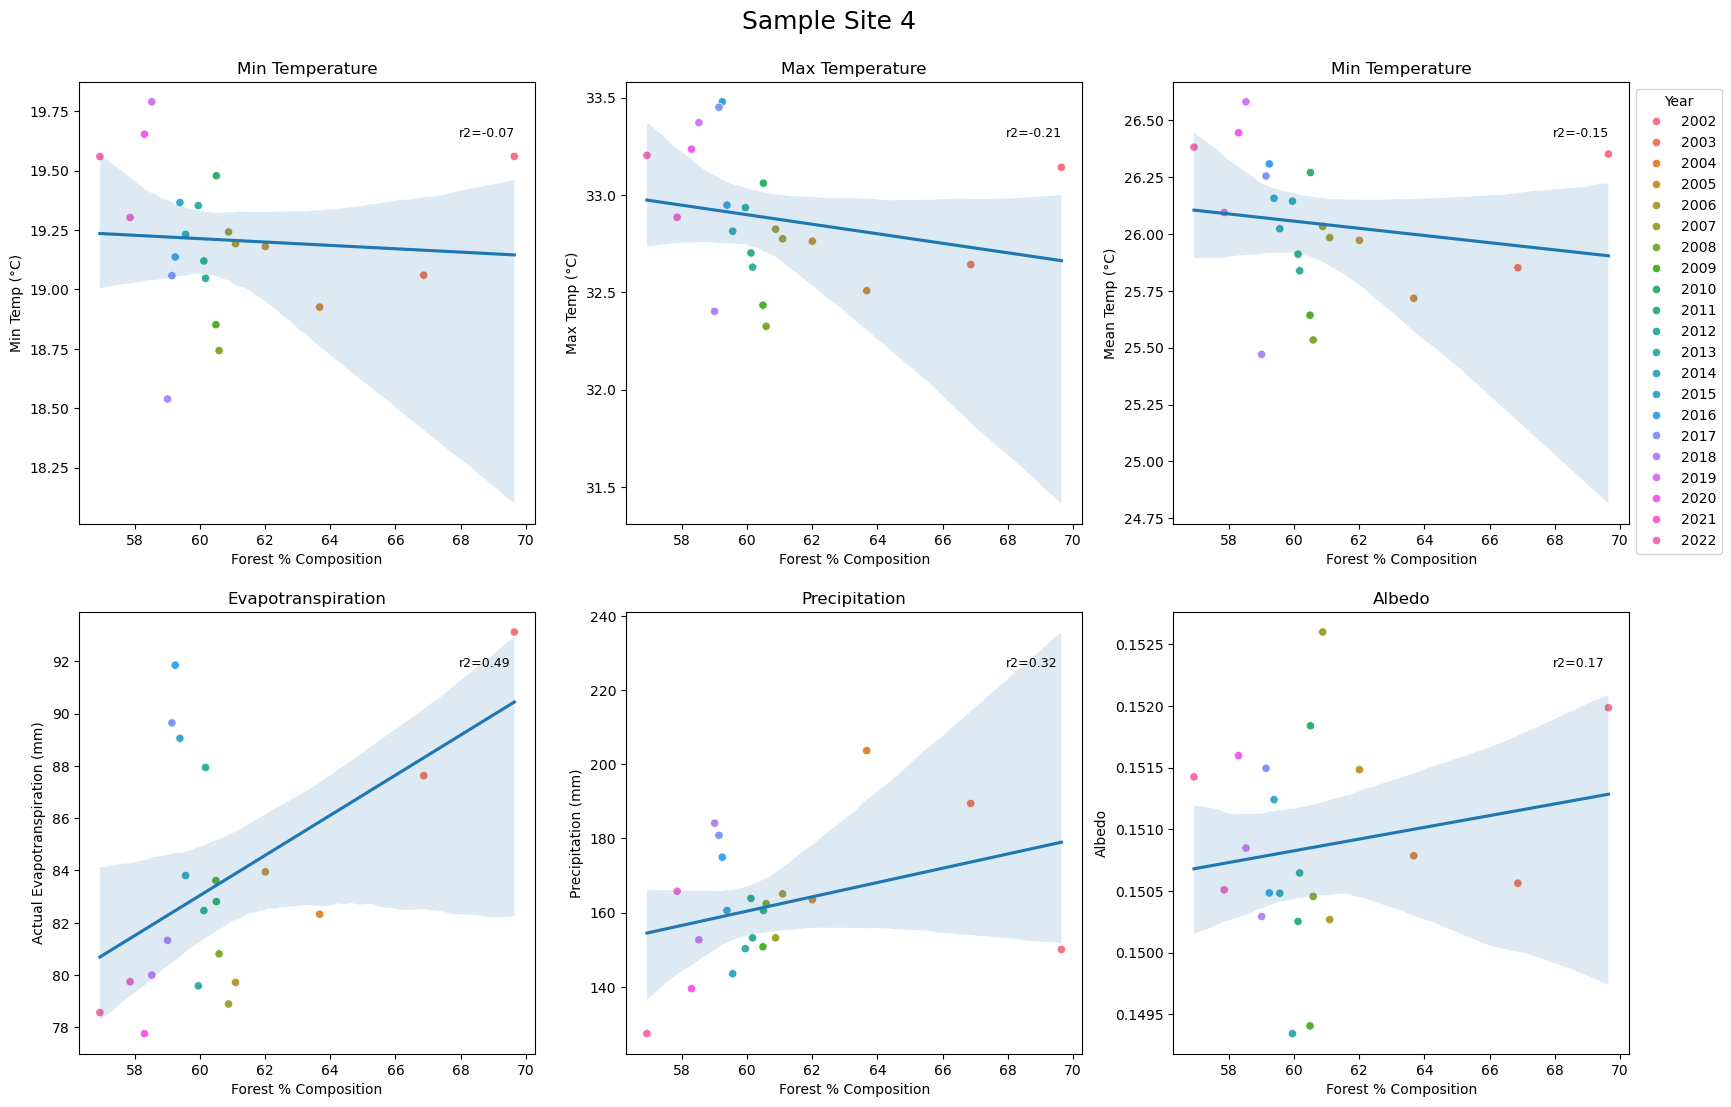

In [809]:
linear_regression('Sample Site 4','Forest')

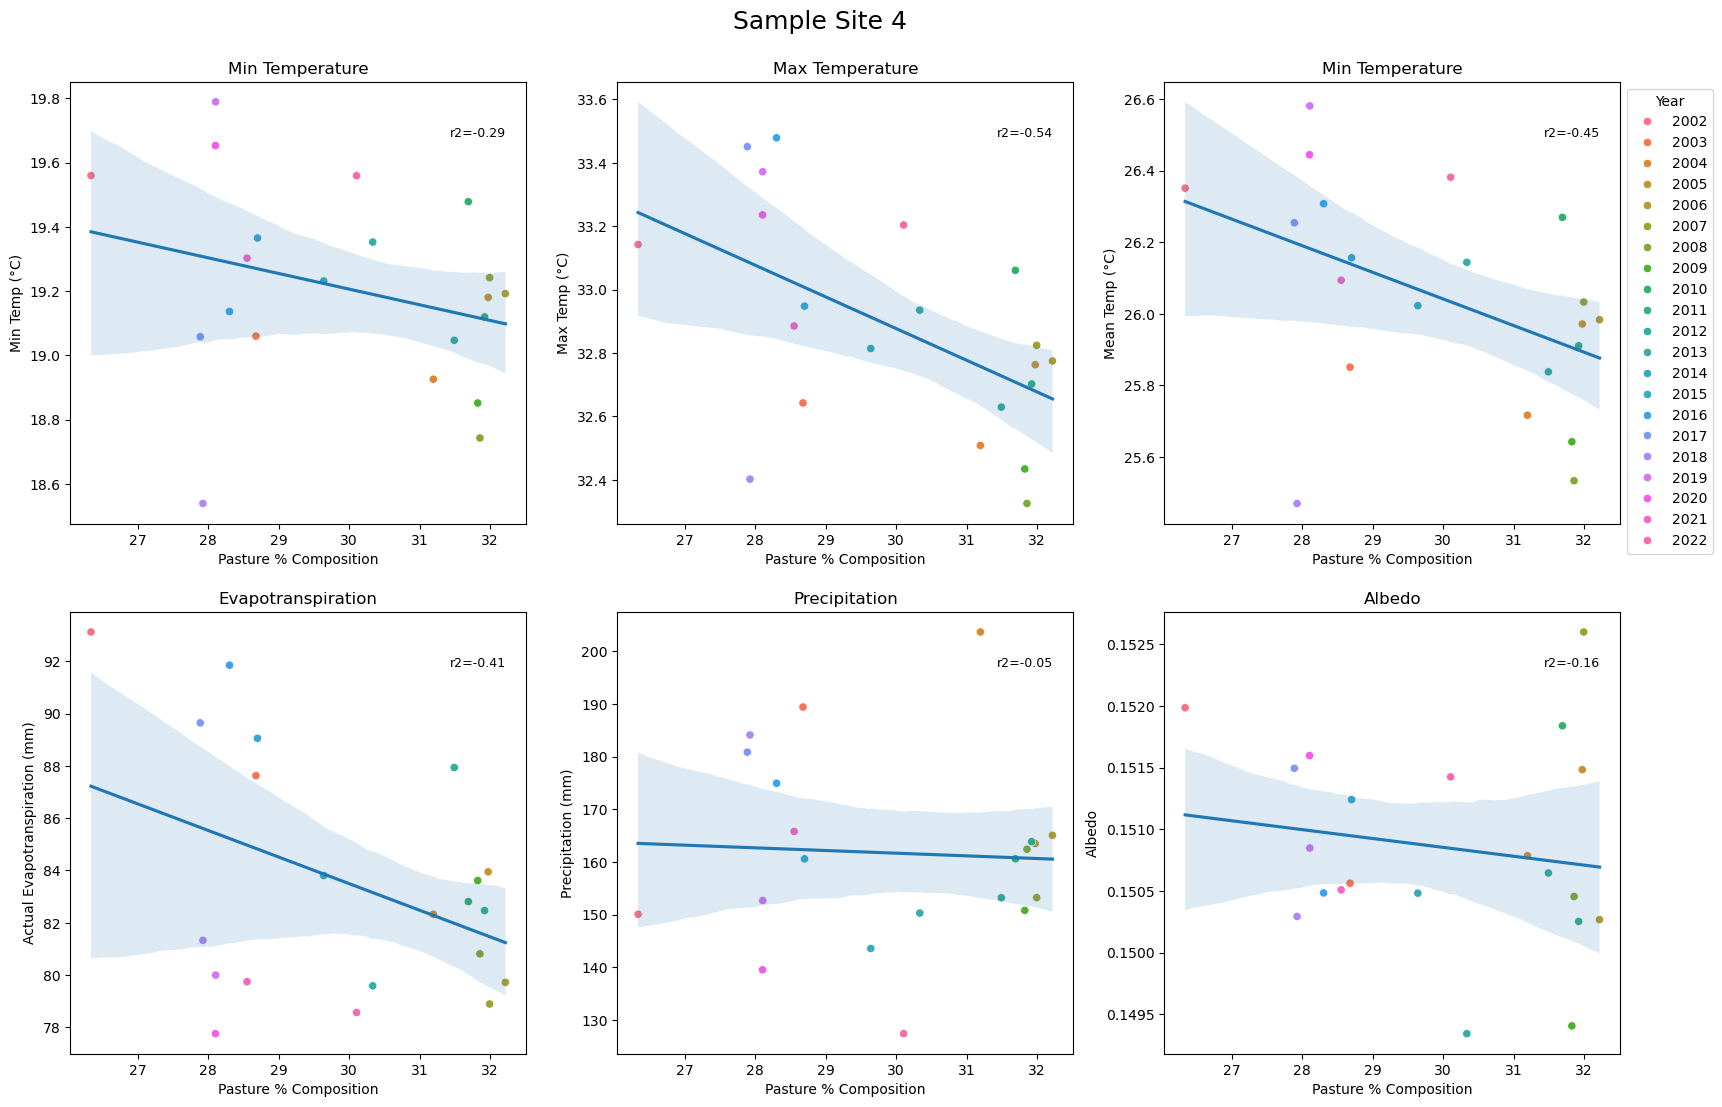

In [812]:
linear_regression('Sample Site 4','Pasture')

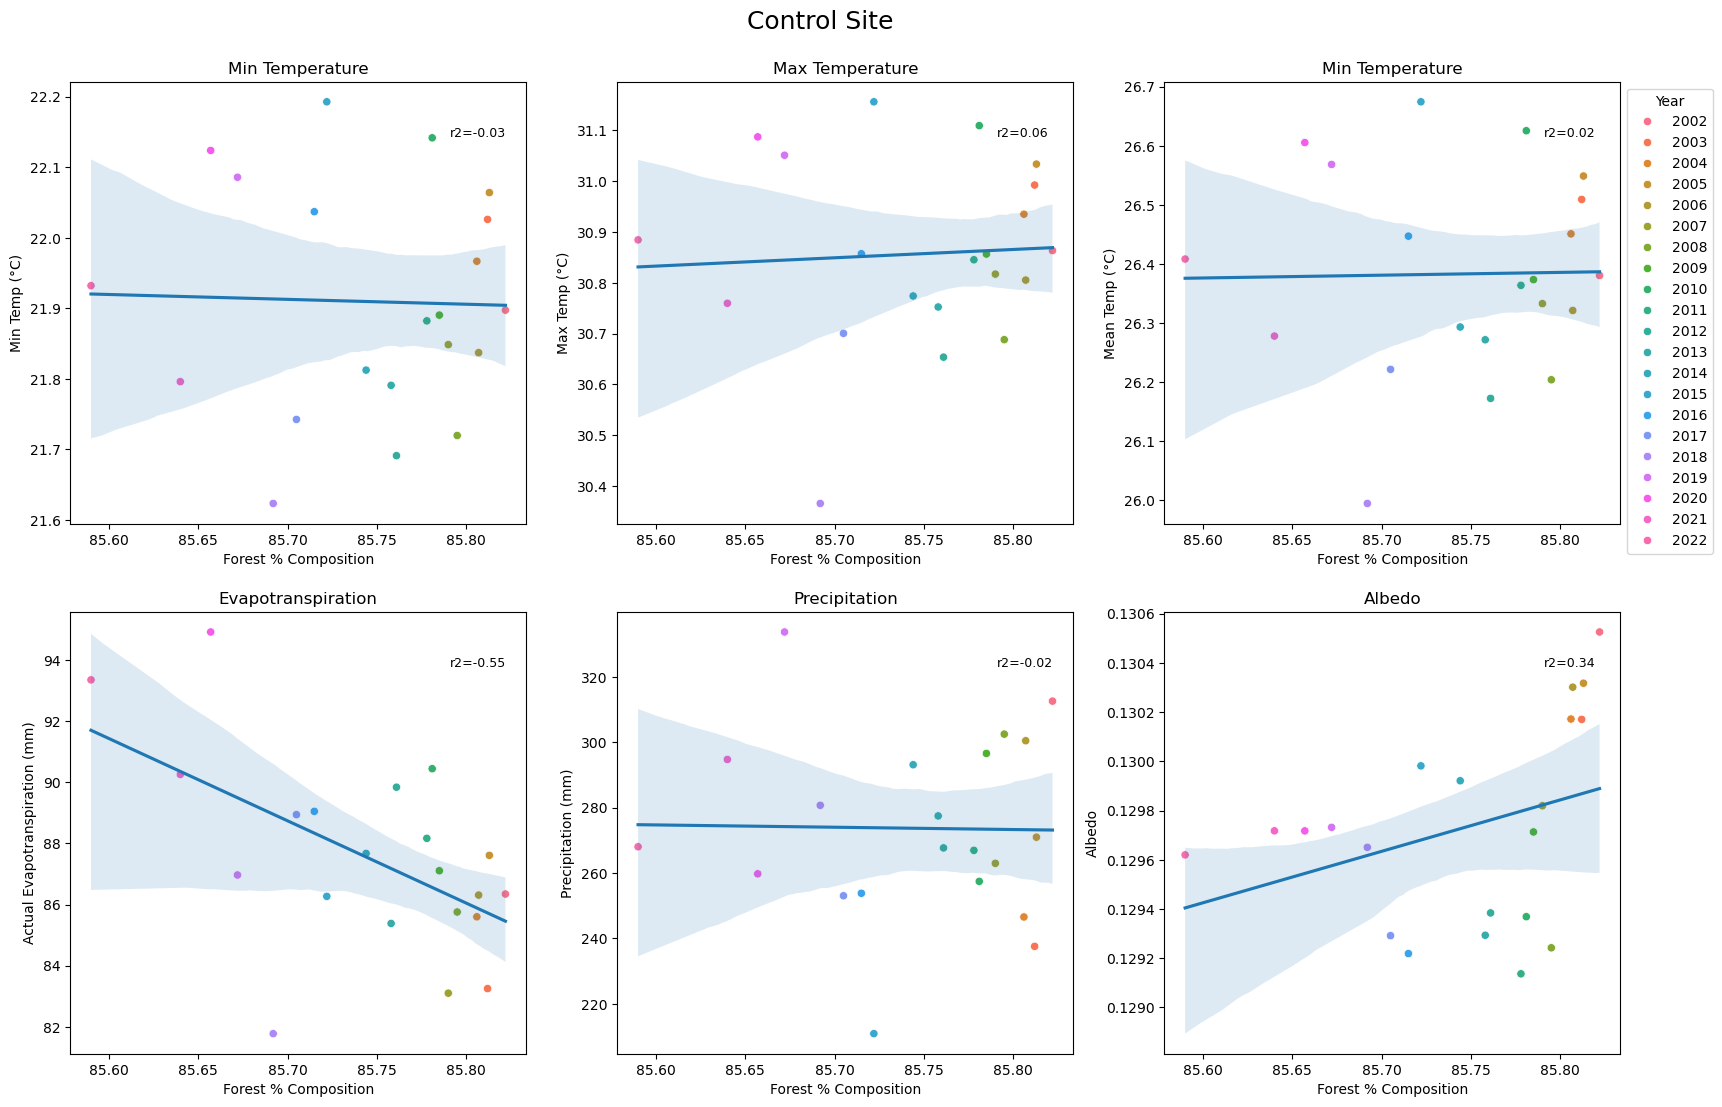

In [813]:
linear_regression('Control Site','Forest')

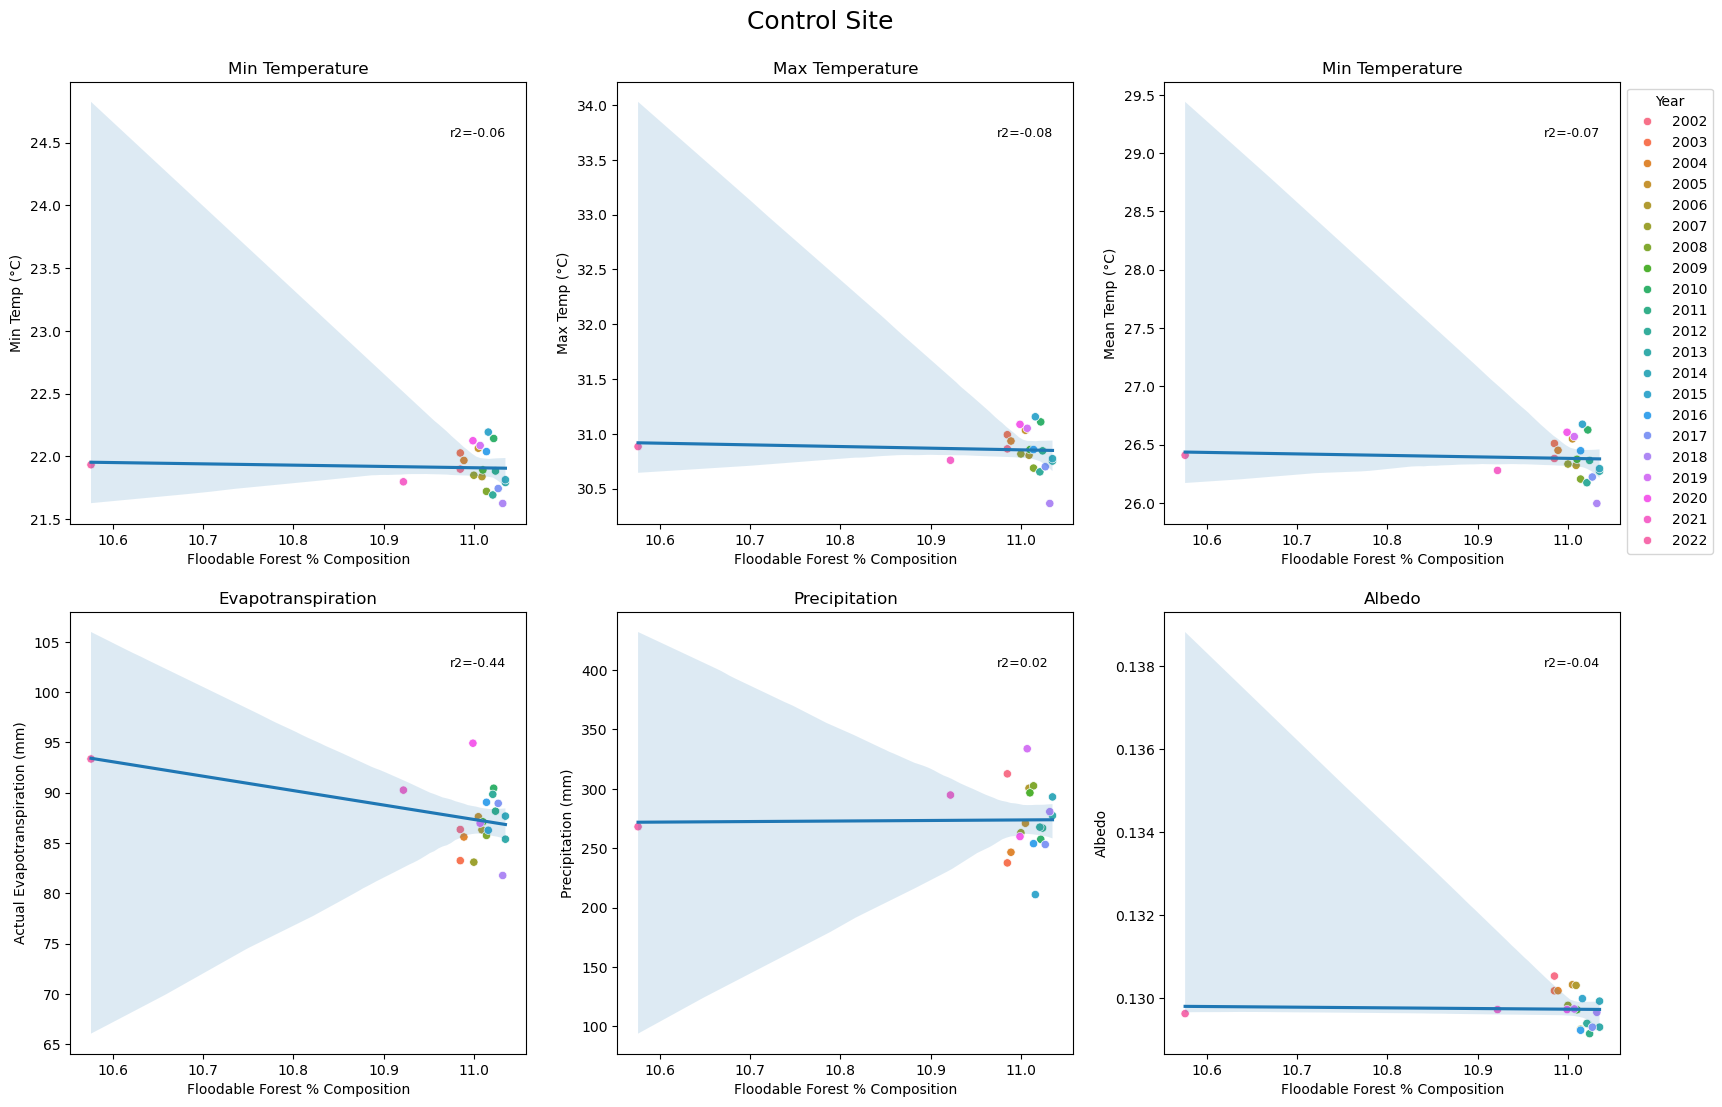

In [814]:
linear_regression('Control Site','Floodable Forest')

In [821]:
def combined_site(colorpalette,veg_variable):
    
    """ 
    This function plots all of the climate data 
    
    colorpalette = matplotlib or seaborn colours - please note that discrete colourmaps should be used, otherwise only every 4th year will plot due to there not being enough variation.
    
    """
    
    
    #import all climate data for all sites
#     sitecontroldf = pd.read_csv('vegetation_climate_data_Control Site.csv')
    site1df = pd.read_csv('vegetation_climate_data_Sample Site 1.csv')
    site2df = pd.read_csv('vegetation_climate_data_Sample Site 2.csv')
    site3df = pd.read_csv('vegetation_climate_data_Sample Site 3.csv')
    site4df = pd.read_csv('vegetation_climate_data_Sample Site 4.csv')

    #combine all climate data together
    combined = pd.concat([site1df, site2df, site3df, site4df
#                           , sitecontroldf
                         ], ignore_index=True)

    #define plotting region (2 rows, 3 columns) and colour palette
    fig, axes = plt.subplots(2, 3,figsize=(20, 12))
    veg_variable='Forest'

    #create scatter plot for each variable
    fig.suptitle('Combined Sites', fontsize=18)    
    fig.subplots_adjust(top = 0.92)

    r1, p1 = sp.stats.pearsonr(x=combined[veg_variable], y=combined['tmin'])
    r1value = str('r2={:.2f}'.format(r1))
    ax1 = sns.scatterplot(x = veg_variable, y = 'tmin', data=combined, hue='Year',palette=colorpalette,ax=axes[0,0],legend=False)
    ax1 = sns.regplot(x = veg_variable, y = 'tmin', data=combined, fit_reg=True,scatter=False,ax=axes[0,0]
                     ).set(title='Min Temperature')
    y1min, y1max = axes[0,0].get_ylim()
    label1y = y1max-((y1max-y1min)/8)
    x1min, x1max = axes[0,0].get_xlim()
    label1x = x1max-((x1max-x1min)/6)
    axes[0,0].text(label1x, label1y,r1value, fontsize=9)
    axes[0,0].set_xlabel(str(veg_variable)+' % Composition')
    axes[0,0].set_ylabel('Min Temp (°C)')

    r2, p2 = sp.stats.pearsonr(x=combined[veg_variable], y=combined['tmax'])
    r2value = str('r2={:.2f}'.format(r2))
    ax2 = sns.scatterplot(x = veg_variable, y = 'tmax', data=combined, hue='Year',palette=colorpalette,ax=axes[0,1],legend=False)
    ax2 = sns.regplot(x = veg_variable, y = 'tmax', data=combined, fit_reg=True,scatter=False,ax=axes[0,1],
                      ).set(title='Max Temperature')
    y2min, y2max = axes[0,1].get_ylim()
    label2y = y2max-((y2max-y2min)/8)
    x2min, x2max = axes[0,1].get_xlim()
    label2x = x2max-((x2max-x2min)/6)
    axes[0,1].text(label2x, label2y,r2value, fontsize=9)
    axes[0,1].set_xlabel(str(veg_variable)+' % Composition')
    axes[0,1].set_ylabel('Max Temp (°C)')

    r3, p3 = sp.stats.pearsonr(x=combined[veg_variable], y=combined['mean temp'])
    r3value = str('r2={:.2f}'.format(r3))
    ax3 = sns.scatterplot(x = veg_variable, y = 'mean temp', data=combined, hue='Year',palette=colorpalette,ax=axes[0,2],legend=True)
    sns.move_legend(ax3, "upper left", bbox_to_anchor=(1, 1))
    ax3 = sns.regplot(x = veg_variable, y = 'mean temp', data=combined, fit_reg=True,scatter=False,ax=axes[0,2],
                     ).set(title='Min Temperature')
    y3min, y3max = axes[0,2].get_ylim()
    label3y = y3max-((y3max-y3min)/8)
    x3min, x3max = axes[0,2].get_xlim()
    label3x = x3max-((x3max-x3min)/6)
    axes[0,2].text(label3x, label3y,r3value, fontsize=9)
    axes[0,2].set_xlabel(str(veg_variable)+' % Composition')
    axes[0,2].set_ylabel('Mean Temp (°C)')

    r4, p4 = sp.stats.pearsonr(x=combined[veg_variable], y=combined['aet'])
    r4value = str('r2={:.2f}'.format(r4))
    ax4 = sns.scatterplot(x = veg_variable, y = 'aet', data=combined, hue='Year',palette=colorpalette,ax=axes[1,0],legend=False)
    ax4 = sns.regplot(x = veg_variable, y = 'aet', data=combined, fit_reg=True,scatter=False,ax=axes[1,0],
                      ).set(title='Evapotranspiration')
    y4min, y4max = axes[1,0].get_ylim()
    label4y = y4max-((y4max-y4min)/8)
    x4min, x4max = axes[1,0].get_xlim()
    label4x = x4max-((x4max-x4min)/6)
    axes[1,0].text(label4x, label4y,r4value, fontsize=9)
    axes[1,0].set_xlabel(str(veg_variable)+' % Composition')
    axes[1,0].set_ylabel('Actual Evapotranspiration (mm)')

    r5, p5 = sp.stats.pearsonr(x=combined[veg_variable], y=combined['ppt'])
    r5value = str('r2={:.2f}'.format(r5))
    ax5 = sns.scatterplot(x = veg_variable, y = 'ppt', data=combined, hue='Year',palette=colorpalette,ax=axes[1,1],legend=False)
    ax5 = sns.regplot(x = veg_variable, y = 'ppt', data=combined, fit_reg=True,scatter=False,ax=axes[1,1],
                      ).set(title='Precipitation')
    y5min, y5max = axes[1,1].get_ylim()
    label5y = y5max-((y5max-y5min)/8)
    x5min, x5max = axes[1,1].get_xlim()
    label5x = x5max-((x5max-x5min)/6)
    axes[1,1].text(label5x, label5y,r5value, fontsize=9)
    axes[1,1].set_xlabel(str(veg_variable)+' % Composition')
    axes[1,1].set_ylabel('Precipitation (mm)')

    r6, p6 = sp.stats.pearsonr(x=combined[veg_variable], y=combined['albedo'])
    r6value = str('r2={:.2f}'.format(r6))
    ax6 = sns.scatterplot(x = veg_variable, y = 'albedo', data=combined, hue='Year',palette=colorpalette,ax=axes[1,2],legend=False)
    ax6 = sns.regplot(x = veg_variable, y = 'albedo', data=combined, fit_reg=True,scatter=False,ax=axes[1,2],
                      ).set(title='Albedo')
    y6min, y6max = axes[1,2].get_ylim()
    label6y = y6max-((y6max-y6min)/8)
    x6min, x6max = axes[1,2].get_xlim()
    label6x = x6max-((x6max-x6min)/6)
    axes[1,2].text(label6x, label6y,r6value, fontsize=9)
    axes[1,2].set_xlabel(str(veg_variable)+' % Composition')
    axes[1,2].set_ylabel('Albedo')
    
    plt.savefig('linear_regression_all_sites_'+str(veg_variable)+'.png', bbox_inches='tight', dpi=100)

    return

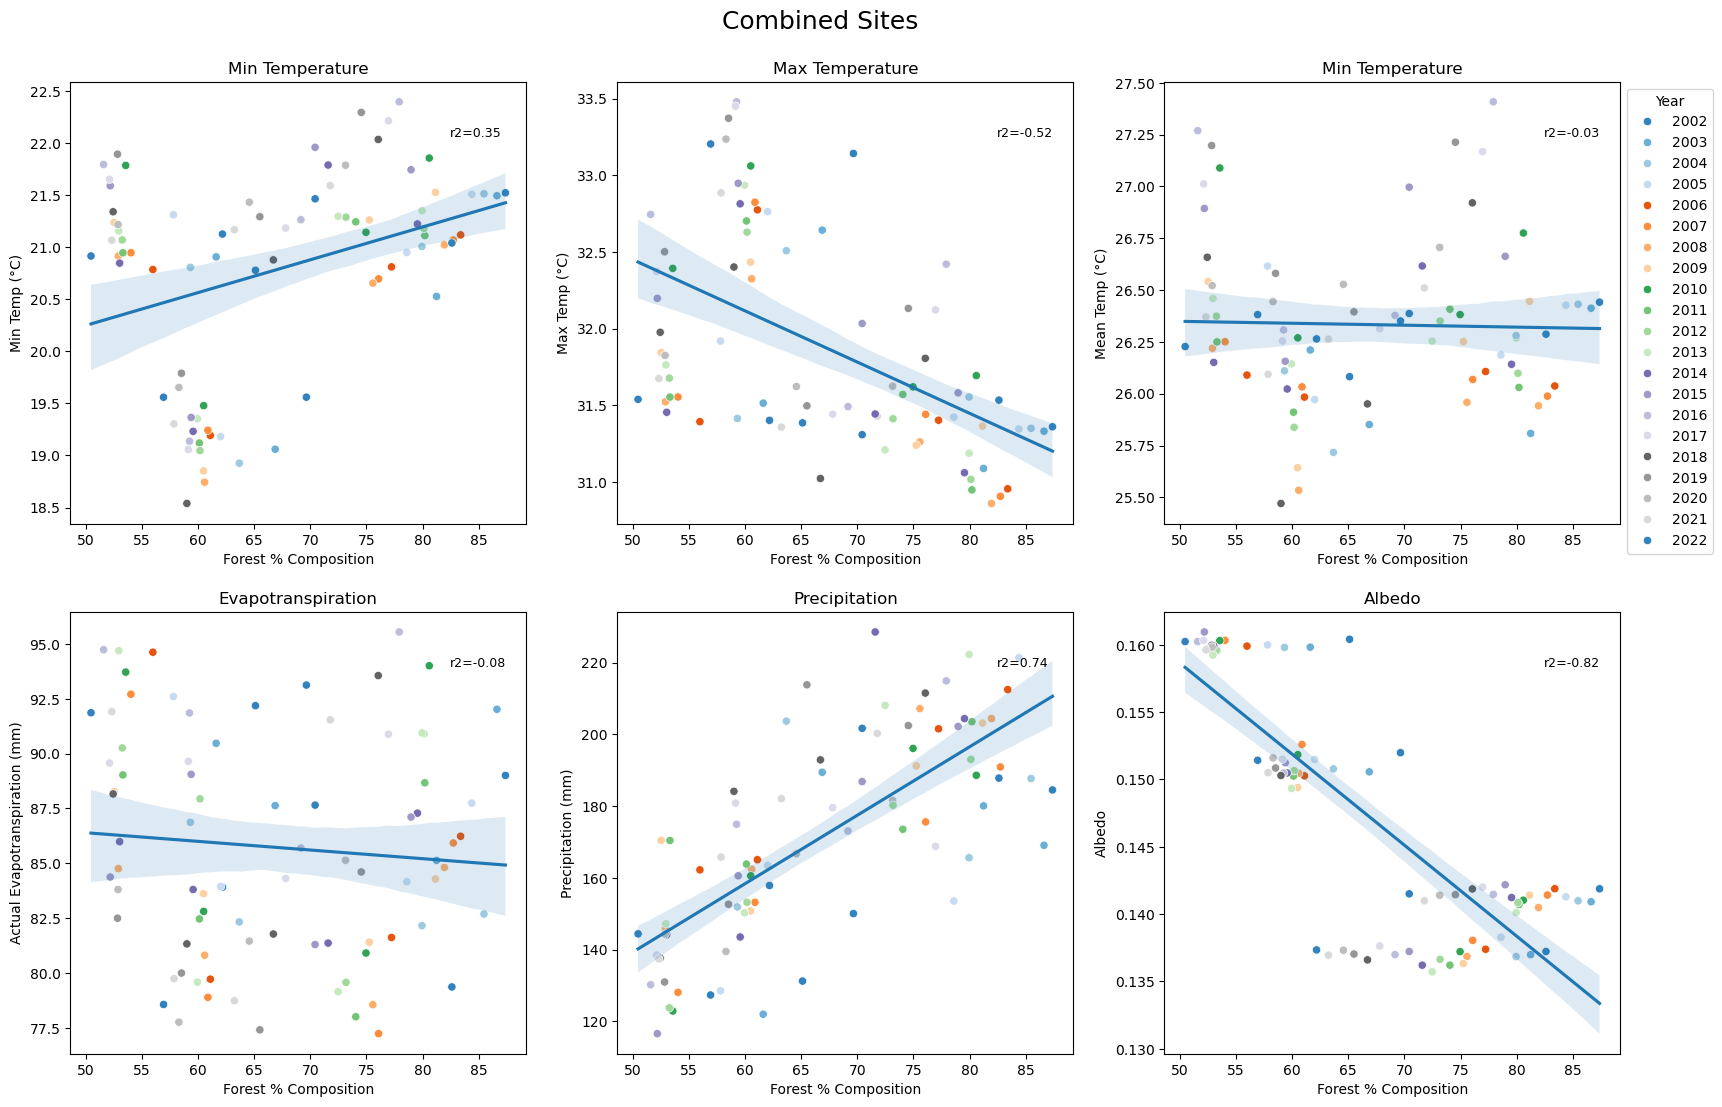

In [822]:
combined_site('tab20c')